In [1]:
import os, zipfile
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.svm import SVC

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from preprocessing import SelectMajorCategories
from visualizations import *
from language import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\weldl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Montando o setup do Kaggle

In [2]:
if 'google.colab' in str(get_ipython()):
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle/"
    on_colab = True
    ! pip install kaggle --upgrade
else:
    os.environ['KAGGLE_CONFIG_DIR'] = "../../Kaggle/"
    on_colab = False

In [4]:
# Downloading and extracting the data from Kaggle
if on_colab:
    dataset_folder = "./"
    ! kaggle competitions download -c i2a2-nlp-2021-sentiment-analysis
    ! unzip -q i2a2-nlp-2021-sentiment-analysis.zip -d "./i2a2-nlp-2021-sentiment-analysis/"
    ! rm i2a2-nlp-2021-sentiment-analysis.zip
else:
    dataset_folder = "C:\\Users\\weldl\\datasets\\i2a2-nlp-2021-sentiment-analysis"
    if not os.path.isdir(dataset_folder):
        ! kaggle competitions download -c i2a2-nlp-2021-sentiment-analysis -p "C:\\Users\\weldl\\datasets"
        # Create a ZipFile Object and load sample.zip in it
        zip_file = dataset_folder + ".zip"
        with ZipFile(zip_file, 'r') as zipObj:
           # Extract all the contents of zip file in different directory
           zipObj.extractall(dataset_folder)
        os.remove(zip_file)

In [5]:
df_train = pd.read_csv(os.path.join(dataset_folder, "train.csv"), low_memory=False)
df_test = pd.read_csv(os.path.join(dataset_folder, "test.csv"), low_memory=False)

# Data Preparation:

In [6]:
target_col = 'rating'

In [7]:
x_train = df_train.drop(columns=[target_col])
y_train = df_train[[target_col]]

x_test = df_test

# Pre-processing

In [8]:
# Selecting the major categories in the categorical features:
cat_features = ['reviewer_gender', 'reviewer_state', 'product_brand', 'site_category_lv1', 'site_category_lv2']
sel = SelectMajorCategories(columns=cat_features, perc=0.01)
sel.fit(x_train)

x_train = sel.transform(x_train)
x_test = sel.transform(x_test)

C:\Users\weldl\Google Drive\Kaggle\i2a2-nlp-2021-sentiment-analysis\preprocessing.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df_[col][~np.isin(x_df[col], self.major_categories[col])] = self.minor_label


In [9]:
# Encoding text columns:
pt_stp_words = stopwords.words('portuguese')

def column_vectorizer(df_train, df_test, col, max_features=100):
    corpus = df_train[col].values
    vectorizer = TfidfVectorizer(strip_accents='unicode', lowercase=True, stop_words=pt_stp_words,
                               max_features=max_features, ngram_range=(1, 3))
    vectorizer.fit(corpus)

    df_train_tfidf = vectorizer.transform(df_train[col])
    tfidf_cols = [f'tfidf_{col}_{i}' for i in range(df_train_tfidf.shape[1])]
    df_train_tfidf = pd.DataFrame(df_train_tfidf.toarray(), columns=tfidf_cols)
    df_train = pd.concat([df_train, df_train_tfidf], axis=1)
    df_test_tfidf = vectorizer.transform(df_test[col])
    df_test_tfidf = pd.DataFrame(df_test_tfidf.toarray(), columns=tfidf_cols)
    df_test = pd.concat([df_test, df_test_tfidf], axis=1)

    return df_train, df_test, tfidf_cols

text_features = []
# review_title:
x_train, x_test, tfidf_cols = column_vectorizer(x_train, x_test, 'review_title', max_features=50)
text_features += tfidf_cols
# review_text:
x_train, x_test, tfidf_cols = column_vectorizer(x_train, x_test, 'review_text', max_features=100)
text_features += tfidf_cols

c:\users\weldl\miniconda3\envs\i2a2-nlp\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ate', 'eramos', 'estao', 'estavamos', 'estiveramos', 'estivessemos', 'foramos', 'fossemos', 'ha', 'hao', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'ja', 'nao', 'sao', 'sera', 'serao', 'seriamos', 'so', 'tambem', 'tera', 'terao', 'teriamos', 'tinhamos', 'tiveramos', 'tivessemos', 'voce', 'voces'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [10]:
x_train

,id,submission_date,review_title,review_text,reviewer_id,reviewer_birth_year,reviewer_gender,reviewer_state,product_id,product_name,...,tfidf_review_text_90,tfidf_review_text_91,tfidf_review_text_92,tfidf_review_text_93,tfidf_review_text_94,tfidf_review_text_95,tfidf_review_text_96,tfidf_review_text_97,tfidf_review_text_98,tfidf_review_text_99
0,0,2018-02-25 04:59:13,Americanas Nao tem compromisso,Comprei um TV Box dia 14 /12/ 2017 e ate agora...,be7443b1b96702ad4599acbb8a034938c5df15f293ff72...,1981.0,F,PE,126831715,Google Chromecast 2,...,0.0,0.0,0.000000,0.306294,0.358718,0.0,0.0,0.0,0.000000,0.0
1,1,2018-03-12 10:13:18,muito bom produto,"Considerando seu custo, é ótimo som com muita ...",75792fad1da46e5ad1d81fd2fd94d6c1b43cacf87fc58d...,1956.0,M,SP,7954368,Caixa Multimidia 2.1 Com Subwoofer 21w Rms Sp-...,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
2,2,2018-01-12 17:20:44,Excelente!,Simplesmente é a melhor que já vi... ela é lin...,6793d62bea0e221898b4b47a2a7079be71c22ea0f35610...,1978.0,F,PR,132381765,"Smart TV LED 43"" Samsung 43MU6100 UHD 4K HDR P...",...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
3,3,2018-03-21 18:18:44,Entrega antes do prazo!,Estou muito satisfeita com o produto é a entre...,ca3562dfc623df2e5055a1d33d8bdce778278e26fb65f1...,1986.0,F,RJ,129605351,"Smart TV LED 32"" SEMP TCL L32S4700S HD com Con...",...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
4,4,2018-05-16 07:29:48,Muito bonito.,A gaiola é muito bonita. Colorida e grande. Al...,7e80e277a30db3bf89095683bf61d39dd8c933c9c7c8e2...,1976.0,F,PR,19956796,Gaiola Para Hamster 3 Andares Vermelha,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92656,92656,2018-03-04 14:10:59,Gostei do Produto,"Comprei o Mixer Cadence ,estou amando fazer mi...",0c4732b96c6332155dd05e927ca0cfe5320d21e88eff59...,1967.0,F,SP,121824196,Mixer Cadence Fast Blend Colors 2 Velocidades ...,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
92657,92657,2018-05-19 09:43:26,Excelente,"Produto atendeu minhas espectativas, chegou co...",326994cdccc9ff5a5c15cc32fc67e926d492c3da182df9...,1984.0,F,BA,132276640,Smartphone Samsung Galaxy J5 Prime Dual Chip A...,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
92658,92658,2018-04-15 14:26:52,OTIMO,MUITO BOM! CHEGOU NO PRAZO CORRETO. VEIO COM T...,44f9ab2dd440f77cadd81a747850c6dc9a59ffaf32553e...,1948.0,F,MG,22878010,"Painel Para Tv Até 40"" 5019 Cor Branco Brilho",...,0.0,0.0,0.442464,0.000000,0.000000,0.0,0.0,0.0,0.379084,0.0
92659,92659,2018-03-28 10:09:35,Produto bom,"Produto bom de qualidade fiquei satisfeito,poi...",a08f56dda47781a7b5da08d6f53a125daaa1afef482a86...,1973.0,M,SP,125768072,Smartphone Samsung Galaxy J1 Mini Dual Chip An...,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0


In [11]:
# Encoding other columns:

# Features groups:
cat_features = ['reviewer_gender', 'reviewer_state', 'product_brand', 'site_category_lv1', 'site_category_lv2']
num_float_features = ['reviewer_birth_year']
passthrough_features = [] + text_features

# Features transformers:
cat_transformer = ('cat', Pipeline([('cat_imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='none')),
                                    ('one-hot', OneHotEncoder(handle_unknown='ignore'))]), cat_features)
num_float_transformer = ('num_float', Pipeline([('num_float_imputer', SimpleImputer(missing_values=np.nan, strategy='mean')), 
                                                ('num_float_scaler', MinMaxScaler()),]), num_float_features)
passthrough_transformer = ('passthrough', 'passthrough', passthrough_features)

transformers = [cat_transformer, num_float_transformer, passthrough_transformer]
feat_encoding = ColumnTransformer(transformers, remainder='drop')

In [12]:
# Features creation:

In [13]:
# Features Selection:

In [14]:
# Pre-processing pipeline:
preprocessor = Pipeline([('features encoding', feat_encoding)])

In [15]:
x_train_encoded = preprocessor.fit_transform(x_train)
x_test_encoded = preprocessor.transform(x_test.loc[:, x_train.columns])

# Model Training

In [16]:
n_jobs = 4

In [17]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [5, 10, 20, 30, 40, 50],
    'max_features': ["auto"],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [8, 10, 12, 14, 16],
    'n_estimators': [1, 5, 10, 20, 30, 40, 50],
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
clf_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                         cv=5, n_jobs=n_jobs, verbose=2, n_iter=12)
clf_rf.fit(x_train_encoded, y_train)
rf_metrics = pd.DataFrame(clf_rf.cv_results_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\weldl\miniconda3\envs\i2a2-nlp\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [19]:
# Create the parameter grid based on the results of random search 
param_grid = {'metric': ['minkowski', 'euclidean', 'manhattan'],
              'weights': ['uniform', 'distance'],
              'n_neighbors': np.array([3, 4, 5, 6, 7, 8, 9])}

# Create a based model
knn = KNeighborsClassifier()
# Instantiate the grid search model
clf_knn = RandomizedSearchCV(estimator=knn, param_distributions=param_grid,
                             cv=5, n_jobs=n_jobs, verbose=2, n_iter=8)
clf_knn.fit(x_train_encoded, y_train)
knn_metrics = pd.DataFrame(clf_knn.cv_results_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\users\weldl\miniconda3\envs\i2a2-nlp\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


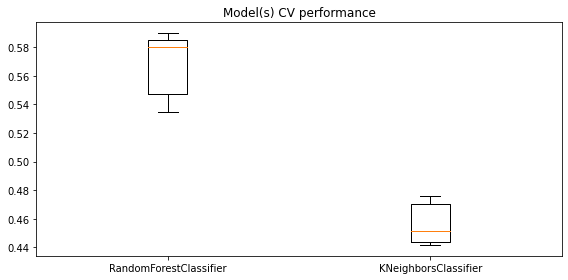

In [20]:
estimators_list = [clf_rf, clf_knn]
plot_estimators_cvperf(estimators_list)

In [21]:
# Selecting the optimal model and Re-fiting with the whole training dataset:
estimators_cvperf = [pd.DataFrame(estimator.cv_results_)['mean_test_score'].max() for estimator in estimators_list]
clf_opt = estimators_list[np.argmax(estimators_cvperf)]
model = clf_opt.best_estimator_.fit(x_train_encoded, y_train)
model

<ipython-input-21-3179d4adfa7c>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = clf_opt.best_estimator_.fit(x_train_encoded, y_train)


RandomForestClassifier(bootstrap=False, max_depth=50, min_samples_leaf=9,
                       min_samples_split=16, n_estimators=10)

# Submission

In [22]:
rating = model.predict(x_test_encoded)
df_submission = pd.DataFrame({"id": [i for i in range(x_test_encoded.shape[0])],
                              "rating": rating})
df_submission

,id,rating
0,0,4
1,1,1
2,2,3
3,3,1
4,4,1
...,...,...
39707,39707,1
39708,39708,5
39709,39709,1
39710,39710,4


In [23]:
submition_file = './submition_file.csv'
df_submission.to_csv(submition_file, index=False)

In [24]:
# !kaggle competitions list

In [25]:
# !kaggle competitions submit -c i2a2-nlp-2021-sentiment-analysis -f submition_file.csv -m "Model 03: tfidf vectorizer full"